# # Architectural Hyperparameter Tuning
# Focus: hidden_dim, num_layers, activation, optimizer_type

In [8]:
#############################################
# Step 1: Data and Fixed Parameters
#############################################
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import joblib
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Load data and artifacts
X_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\X_train.csv")
y_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\y_train.csv")
scaler = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\standard_scaler.pkl")
cat_vocab = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_vocab.pkl")

# Fixed parameters from best configuration
FIXED_PARAMS = {
    'w1': 0.2, 'w2': 0.55, 'lambda_eng': 0.15,
    'lr': 0.001, 'batch_size': 40, 'T_train': 800
}

# Feature setup
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']
eng_indices = [numeric_features.index(f) for f in ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']]

# Filter and prepare data
fraud_mask = (y_train_df.iloc[:, 0] == 1)
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values
X_nonfraud_num = X_train_df[numeric_features].loc[~fraud_mask].values

# Engineered feature constraints
eng_min = torch.tensor(np.min(X_train_num[:, eng_indices], axis=0), 
                      dtype=torch.float32, device='cuda' if torch.cuda.is_available() else 'cpu')
eng_max = torch.tensor(np.max(X_train_num[:, eng_indices], axis=0),
                     dtype=torch.float32, device='cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
#############################################
# Step 2: Dataset and Model Setup
#############################################
class FraudDataset(Dataset):
    def __init__(self, num_data, cat_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
    def __len__(self): return len(self.num_data)
    def __getitem__(self, idx): return self.num_data[idx], self.cat_data[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beta = torch.linspace(1e-4, 0.02, FIXED_PARAMS['T_train']).to(device)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)


In [10]:
#############################################
# Step 3: Model Architecture
#############################################
class AdvancedNoisePredictor(nn.Module):
    def __init__(self, num_input_dim, cat_vocab_sizes, 
                 hidden_dim=256, num_layers=2, 
                 activation='LeakyReLU', cat_embed_dim=2):
        super().__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab_size in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab_size, cat_embed_dim)
        
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(num_input_dim + cat_total_dim + 1, hidden_dim),
            self._get_activation(activation),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                self._get_activation(activation)
              ) for _ in range(num_layers-1)],
            nn.Linear(hidden_dim, num_input_dim)
        )

    def _get_activation(self, name):
        return {'LeakyReLU': nn.LeakyReLU(), 'GELU': nn.GELU()}[name]

    def forward(self, x_num, x_cat, t):
        embeds = [self.embeddings[col](x_cat[:,i]) for i,col in enumerate(self.embeddings)]
        x = torch.cat([x_num, *embeds, (t.float()/FIXED_PARAMS['T_train']).unsqueeze(1)], dim=1)
        return self.mlp(x)

In [11]:
#############################################
# Step 4: Training Infrastructure
#############################################
def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0)
    return sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise, noise

def train_arch_config(config):
    model = AdvancedNoisePredictor(
        num_input_dim=len(numeric_features),
        cat_vocab_sizes={col: cat_vocab[col] for col in cat_features},
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        activation=config['activation']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=FIXED_PARAMS['lr']) if config['optimizer_type'] == 'Adam' else \
               optim.AdamW(model.parameters(), lr=FIXED_PARAMS['lr'])
    
    train_loader = DataLoader(FraudDataset(X_train_num, X_train_cat), 
                             batch_size=FIXED_PARAMS['batch_size'], shuffle=True)
    
    mu_nf = X_nonfraud_tensor.mean(dim=0)
    sigma_nf = X_nonfraud_tensor.std(dim=0) + 1e-5
    loss_components = {'total': [], 'mse': [], 'prior': [], 'triplet': [], 'eng': []}

    for epoch in range(150):
        model.train()
        epoch_losses = [0]*5  # total, mse, prior, triplet, eng
        
        for x_num, x_cat in train_loader:
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            t = torch.randint(0, FIXED_PARAMS['T_train'], (x_num.size(0),), device=device)
            
            x_t, noise = forward_diffusion(x_num, t)
            pred_noise = model(x_t, x_cat, t)
            
            # Calculate losses
            mse_loss = F.mse_loss(pred_noise, noise)
            z = (pred_noise - mu_nf)/sigma_nf
            prior_loss = (1 - 2*(1 - torch.distributions.Normal(0,1).cdf(torch.abs(z)))).mean()
            x0_est = (x_t - torch.sqrt(1-alpha_hat[t]).unsqueeze(1)*pred_noise)/torch.sqrt(alpha_hat[t]).unsqueeze(1)
            rand_idx = torch.randint(0, len(X_nonfraud_tensor), (x_num.size(0),))
            triplet_loss = F.relu(F.pairwise_distance(x0_est, x_num) - 
                                 F.pairwise_distance(x0_est, X_nonfraud_tensor[rand_idx]) + 1).mean()
            eng_loss = torch.mean(F.relu(eng_min - x0_est[:,eng_indices]) + 
                                F.relu(x0_est[:,eng_indices] - eng_max))
            
            total_loss = (mse_loss + FIXED_PARAMS['w1']*prior_loss + 
                        FIXED_PARAMS['w2']*triplet_loss + FIXED_PARAMS['lambda_eng']*eng_loss)
            
            # Optimization step
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            # Accumulate losses
            losses = [total_loss.item(), mse_loss.item(), prior_loss.item(), 
                     triplet_loss.item(), eng_loss.item()]
            for i in range(5): epoch_losses[i] += losses[i]
        
        # Store and print metrics
        batches = len(train_loader)
        for i, key in enumerate(loss_components): 
            loss_components[key].append(epoch_losses[i]/batches)
            
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/150 | "
                  f"Total: {loss_components['total'][-1]:.4f} | "
                  f"MSE: {loss_components['mse'][-1]:.4f} | "
                  f"Prior: {loss_components['prior'][-1]:.4f} | "
                  f"Triplet: {loss_components['triplet'][-1]:.4f} | "
                  f"Eng: {loss_components['eng'][-1]:.4f}")
    
    return model, loss_components

In [12]:
#############################################
# Step 5: Evaluation & Visualization
#############################################
def generate_categorical_samples(num_samples):
    synthetic_cat = {}
    for col in cat_features:
        value_counts = pd.Series(X_train_cat[:, cat_features.index(col)]).value_counts(normalize=True)
        synthetic_cat[col] = np.random.choice(value_counts.index, size=num_samples, p=value_counts.values)
    return torch.tensor(pd.DataFrame(synthetic_cat).values, dtype=torch.long)

def generate_samples(model, num_samples=1000):
    model.eval()
    with torch.no_grad():
        synthetic_cat = generate_categorical_samples(num_samples).to(device)
        x_num = torch.randn(num_samples, len(numeric_features)).to(device)
        
        for t in reversed(range(FIXED_PARAMS['T_train'])):
            t_tensor = torch.full((num_samples,), t, device=device)
            pred_noise = model(x_num, synthetic_cat, t_tensor)
            beta_t = beta[t].view(1,1)
            sqrt_alpha_t = torch.sqrt(1 - beta_t)
            x_num = (x_num - beta_t*pred_noise/(torch.sqrt(1 - alpha_hat[t])))/sqrt_alpha_t
            if t > 0: x_num += torch.sqrt(beta_t)*torch.randn_like(x_num)
        
        x_num[:, eng_indices] = torch.clamp(x_num[:, eng_indices], eng_min, eng_max)
        return x_num.cpu().numpy()

def evaluate_model(model):
    synthetic_num = scaler.inverse_transform(generate_samples(model))
    real_num = scaler.inverse_transform(X_train_num)
    return np.mean([wasserstein_distance(real_num[:,i], synthetic_num[:,i]) 
                  for i in range(len(numeric_features))])

def plot_results(results):
    plt.figure(figsize=(15, 6))
    
    # Training curves
    plt.subplot(1, 2, 1)
    for res in results:
        label = f"HD{res['hidden_dim']}-L{res['num_layers']}-{res['activation'][:4]}-{res['optimizer_type']}"
        plt.plot(res['loss_components']['total'], label=label)
    plt.title("Training Loss Curves")
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.05, 1)), plt.grid(True)
    
    # Performance comparison
    plt.subplot(1, 2, 2)
    config_labels = [f"HD{r['hidden_dim']}-L{r['num_layers']}" for r in results]
    wassersteins = [r['wasserstein'] for r in results]
    plt.barh(config_labels, wassersteins)
    plt.title("Wasserstein Distance by Architecture")
    plt.xlabel("Distance"), plt.ylabel("Configuration")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


=== Testing {'hidden_dim': 224, 'num_layers': 2, 'activation': 'LeakyReLU', 'optimizer_type': 'Adam'} ===
Epoch 10/150 | Total: 0.5526 | MSE: 0.3372 | Prior: 0.4276 | Triplet: 0.1458 | Eng: 0.3314
Epoch 20/150 | Total: 0.4805 | MSE: 0.3001 | Prior: 0.4225 | Triplet: 0.1000 | Eng: 0.2732
Epoch 30/150 | Total: 0.4221 | MSE: 0.2617 | Prior: 0.4233 | Triplet: 0.0784 | Eng: 0.2173
Epoch 40/150 | Total: 0.3950 | MSE: 0.2414 | Prior: 0.4222 | Triplet: 0.0716 | Eng: 0.1986
Epoch 50/150 | Total: 0.3654 | MSE: 0.2258 | Prior: 0.4280 | Triplet: 0.0568 | Eng: 0.1520
Epoch 60/150 | Total: 0.3598 | MSE: 0.2173 | Prior: 0.4299 | Triplet: 0.0566 | Eng: 0.1694
Epoch 70/150 | Total: 0.3450 | MSE: 0.2123 | Prior: 0.4302 | Triplet: 0.0494 | Eng: 0.1299
Epoch 80/150 | Total: 0.3293 | MSE: 0.2010 | Prior: 0.4359 | Triplet: 0.0401 | Eng: 0.1271
Epoch 90/150 | Total: 0.3221 | MSE: 0.1960 | Prior: 0.4335 | Triplet: 0.0402 | Eng: 0.1150
Epoch 100/150 | Total: 0.3137 | MSE: 0.1894 | Prior: 0.4357 | Triplet: 0.0

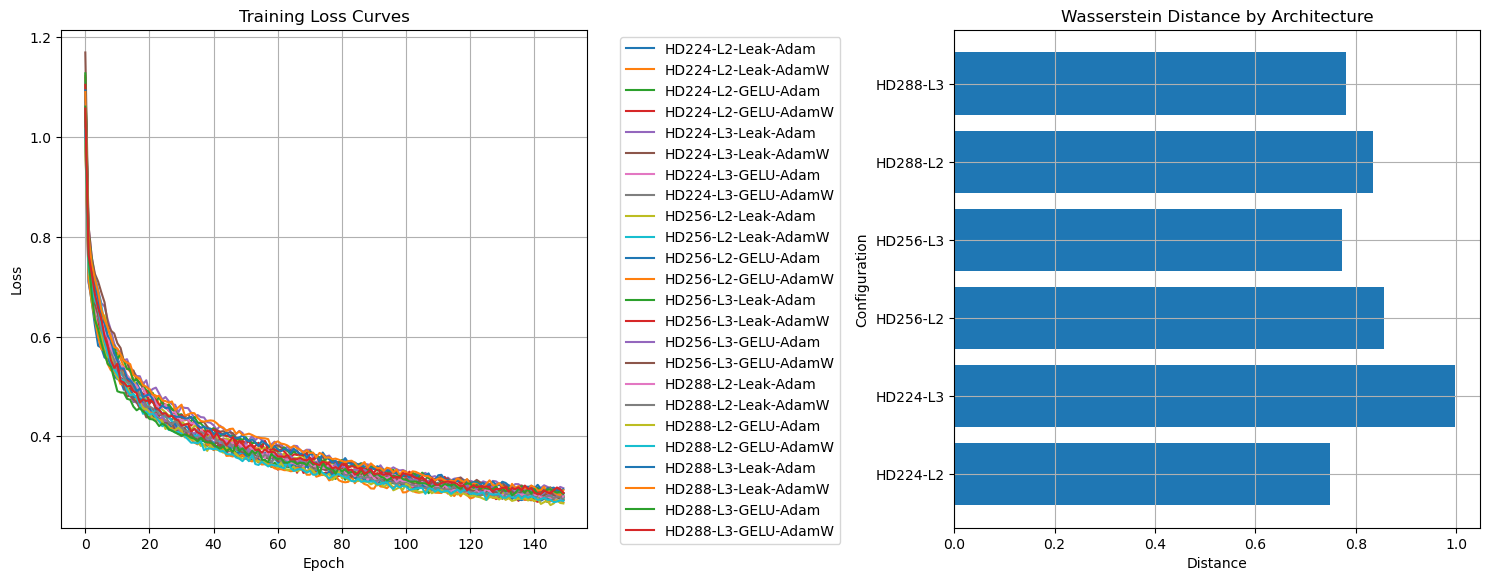

In [13]:
#############################################
# Step 6: Run Architectural Search
#############################################
arch_search_space = {
    'hidden_dim': [224, 256, 288],
    'num_layers': [2, 3],
    'activation': ['LeakyReLU', 'GELU'],
    'optimizer_type': ['Adam', 'AdamW']
}

results = []
for config in [dict(zip(arch_search_space.keys(), vals)) 
              for vals in product(*arch_search_space.values())]:
    
    print(f"\n=== Testing {config} ===")
    model, loss_components = train_arch_config(config)
    ws_dist = evaluate_model(model)
    
    results.append({
        **config,
        'wasserstein': ws_dist,
        'loss_components': loss_components,
        'final_loss': loss_components['total'][-1],
        'min_loss': min(loss_components['total'])
    })
    
    print(f"\nResults for {config}:")
    print(f"  Final Loss: {loss_components['total'][-1]:.4f}")
    print(f"  Min Loss: {min(loss_components['total']):.4f}")
    print(f"  Wasserstein: {ws_dist:.4f}")
    print("----------------------------")

plot_results(results)


=== Testing {'hidden_dim': 512, 'num_layers': 2, 'activation': 'LeakyReLU', 'optimizer_type': 'Adam'} ===
Epoch 10/150 | Total: 0.5585 | MSE: 0.3262 | Prior: 0.4177 | Triplet: 0.1549 | Eng: 0.4232
Epoch 20/150 | Total: 0.4838 | MSE: 0.2958 | Prior: 0.4159 | Triplet: 0.1018 | Eng: 0.3250
Epoch 30/150 | Total: 0.4314 | MSE: 0.2630 | Prior: 0.4181 | Triplet: 0.0856 | Eng: 0.2509
Epoch 40/150 | Total: 0.3944 | MSE: 0.2420 | Prior: 0.4234 | Triplet: 0.0646 | Eng: 0.2146
Epoch 50/150 | Total: 0.3728 | MSE: 0.2262 | Prior: 0.4266 | Triplet: 0.0571 | Eng: 0.1991
Epoch 60/150 | Total: 0.3669 | MSE: 0.2232 | Prior: 0.4328 | Triplet: 0.0526 | Eng: 0.1884
Epoch 70/150 | Total: 0.3442 | MSE: 0.2080 | Prior: 0.4329 | Triplet: 0.0459 | Eng: 0.1621
Epoch 80/150 | Total: 0.3366 | MSE: 0.2057 | Prior: 0.4337 | Triplet: 0.0395 | Eng: 0.1499
Epoch 90/150 | Total: 0.3145 | MSE: 0.1865 | Prior: 0.4397 | Triplet: 0.0381 | Eng: 0.1278
Epoch 100/150 | Total: 0.3074 | MSE: 0.1801 | Prior: 0.4403 | Triplet: 0.0

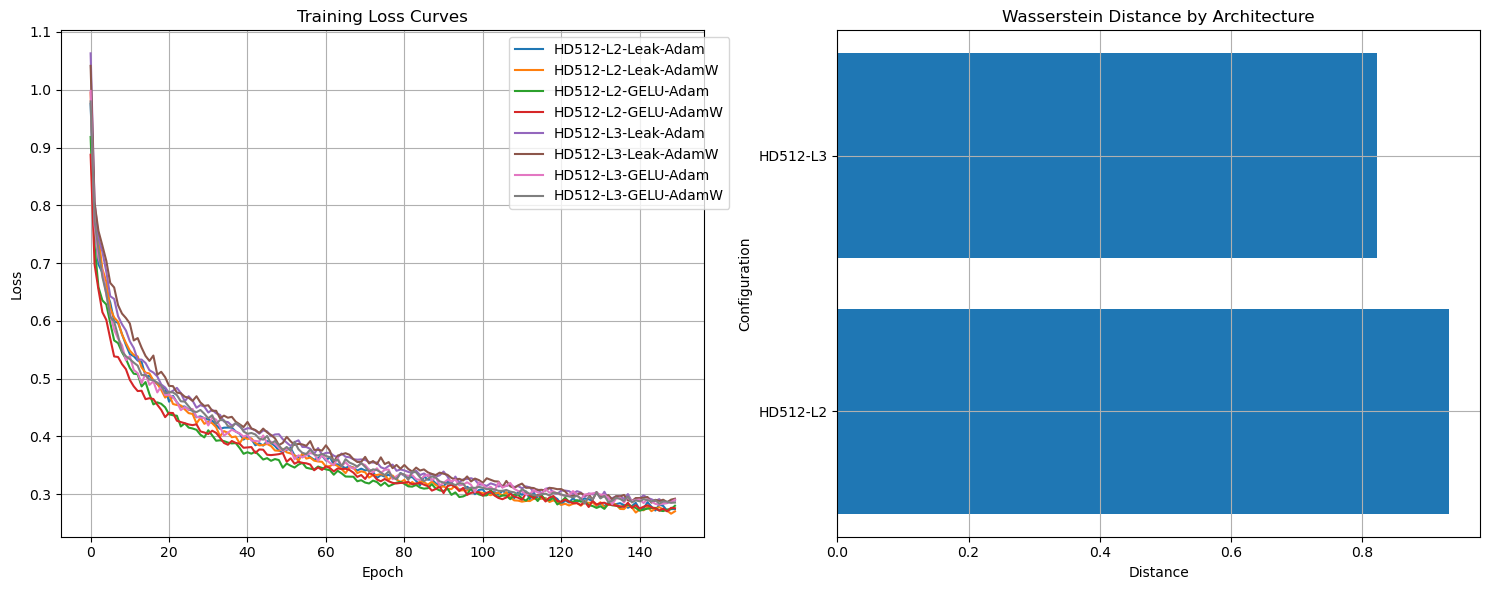

In [15]:
#############################################
# Step 6: Run Architectural Search
#############################################
arch_search_space_1 = {
    'hidden_dim': [512],
    'num_layers': [2, 3],
    'activation': ['LeakyReLU', 'GELU'],
    'optimizer_type': ['Adam', 'AdamW']
}

results1 = []
for config in [dict(zip(arch_search_space_1.keys(), vals)) 
              for vals in product(*arch_search_space_1.values())]:
    
    print(f"\n=== Testing {config} ===")
    model, loss_components = train_arch_config(config)
    ws_dist = evaluate_model(model)
    
    results1.append({
        **config,
        'wasserstein': ws_dist,
        'loss_components': loss_components,
        'final_loss': loss_components['total'][-1],
        'min_loss': min(loss_components['total'])
    })
    
    print(f"\nResults for {config}:")
    print(f"  Final Loss: {loss_components['total'][-1]:.4f}")
    print(f"  Min Loss: {min(loss_components['total']):.4f}")
    print(f"  Wasserstein: {ws_dist:.4f}")
    print("----------------------------")

plot_results(results1)